<font color="sienna">
# Assignment  6

### Graham Smith ~ 912355584

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

<font color="sienna">
## Sources
I referred to the following websites.

<ol>
<li>http://basemaptutorial.readthedocs.io/en/latest/shapefile.html</li>
<li>http://matplotlib.org/users/colormaps.html</li>
<li>http://brandonrose.org/pythonmap</li>
<li>https://geohackweek.github.io/vector/04-geopandas-intro/</li>
</ol>

Also, among other people: Edie Espejo, Patrick Vacek, Niveditha Achanta and Chad Pickering.

In [110]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import re

In [2]:
# DISPLAY PLOTS INLINE
%matplotlib inline

# MAKE 'EM PLOTS BIG
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)

# MAPS
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import shapely.geometry as geom

<font color="sienna">
# Exercise 1.1
 ~ Which mobile food vendor(s) sells at the most locations?
<br><br>
Strategy: In this exercise, I will extract food truck info from the SQL database. First, I will explore what is in the database, then querying accordingly.

In [191]:
db = sql.connect('sf_data.sqlite')
cursor = db.execute("SELECT * FROM sqlite_master")

In [192]:
pd.read_sql("SELECT * FROM sqlite_master", db)

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."


In [5]:
#QUERY INFORMATION FROM DATABASE
df = pd.read_sql("SELECT mobile_food_locations.Address, mobile_food_permits.Applicant \
            FROM mobile_food_locations \
            INNER JOIN mobile_food_schedule \
            ON mobile_food_locations.locationid = mobile_food_schedule.locationid \
            INNER JOIN mobile_food_permits \
            ON mobile_food_permits.permit = mobile_food_schedule.permit \
            WHERE status=='APPROVED' GROUP BY Address", db)

In [194]:
# GET COUNTS OF PERMITS AS A PROXY FOR LOCATION
counts_df = pd.DataFrame(df.Applicant.value_counts())
counts_df.columns = ["Number of Permits"]
counts_df.head()

,Number of Permits
Park's Catering,22
D & T Catering,17
F & C Catering,13
Munch A Bunch,9
Eva's Catering,8


<font color="sienna">
<b>Park's Catering</b> sells in the most locations, with 22 addresses. D&T Catering is second with 17 locations, and F&C Catering is third with 13 locations.

<font color="sienna">
# Exercise 1.2
~ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support     your answer with plots. Make a map for at least 2 of the 5 questions.
<br><br>
I have chosen to answer the following questions:
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(I) What are the most and least expensive parts of the City?
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(II) Where do violent crimes happen? What kinds of violent crime are most common?
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(III) Are different police precincts more likely to arrest people for domestic violence?
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(IV) Is there a relationship between home price and domestic violence arrest rates?
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(V) What's the distribution of high schools in the City?

<font color="sienna">
### (I) What are the most and least expensive parts of the City?
<br>
I will first select the median prices per square foot of homes and the zip codes of the corresponding region.

In [149]:
prices_per_zip = pd.read_sql("SELECT RegionName, MedianSoldPricePerSqft_AllHomes FROM zillow WHERE MedianSoldPricePerSqft_AllHomes>0 GROUP BY RegionName", db)
ppz = prices_per_zip.sort_values(by="MedianSoldPricePerSqft_AllHomes", ascending=False)
top3_bottom3 = ppz.iloc[0:5]

In [8]:
#GET MEDIAN HOME PRICES
np.median(prices_per_zip["MedianSoldPricePerSqft_AllHomes"])

601.74609337592449

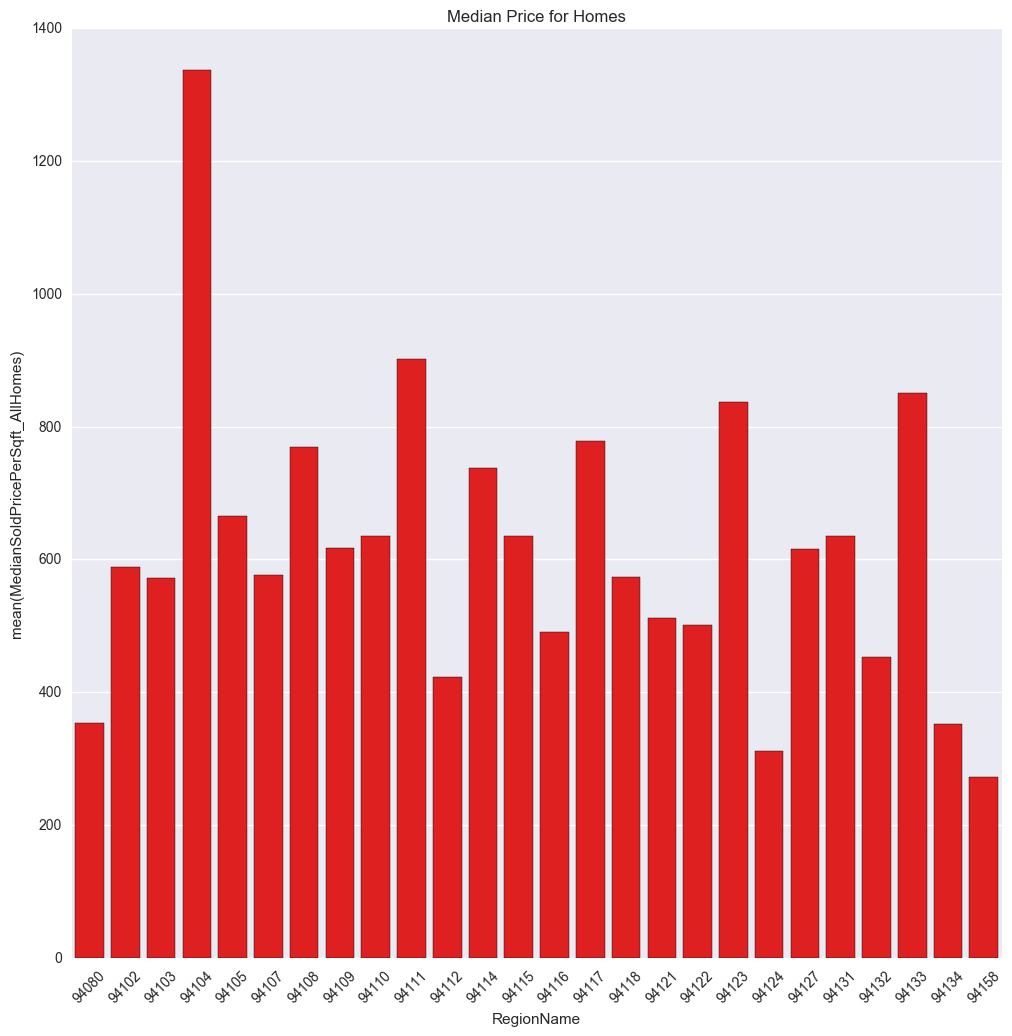

In [200]:
a = sns.barplot(x="RegionName", y="MedianSoldPricePerSqft_AllHomes", data=prices_per_zip,
            label="Total", color="red")

for item in a.get_xticklabels():
    item.set_rotation(45)

plt.title("Median Price for Homes")
plt.show()

<font color="sienna">
<b>Most Expensive Zips of the City</b>
<br>
94104: Downtown, the Financial District
<br>
94111: Embaracdero
<br>
94133: North Beach
<br><br>
<b>Least Expensive Zips of the City</b>
<br>
94134: Visitacion Valley
<br>
94124: Hunter's Point
<br>
94158: Mission Bay
<br>

Most expensive areas break down into two types - high population and low population density. It makes sense, given that the most expensive real estate is going to be either penthouses in highrises, or very large estates in more suburban areas. The low price areas follow a somewhat less predicable pattern. While Vistacion and Hunter's point are both in the outskirts of south SF, Mission Bay and the Tenderloin are both right near downtown. This is likely a factor of the nature in which most American cities developed and is a legacy of the de-urbanization of the 20th century. City centers became the province of the lower classes, and it's only recently that Millenials have started to shift the demographics back in the opposite direction. It IS somewhat surprising that the complaints about gentrification over the past few years still haven't erased this legacy.

<font color="sienna">
### (II) Where do violent crimes happen? What kinds of violent crime are most common?
<br>
I looked at violent crime by police district, then sorted by the most common codes

In [201]:
#I'M DEFINING A VIOLENT CRIME AS ANY THAT CONTAINS THE WORDS VIOLENT/VIOLENCE, ASSAULT OR HOMICIDE
violentCrime = pd.read_sql("SELECT Descript, PdDistrict, Lon, Lat FROM crime WHERE Descript LIKE '%VIOLEN%' \
                    union \
                    SELECT Descript, PdDistrict, Lon, Lat FROM crime WHERE Descript LIKE '%ASSAULT%' \
                    union \
                    SELECT Descript, PdDistrict, Lon, Lat FROM crime WHERE Descript LIKE '%HOMICIDES%'", db)

In [72]:
#DATAFRAME OF DISTRICTS ONLY
districts = pd.DataFrame(violentCrime["PdDistrict"].value_counts())

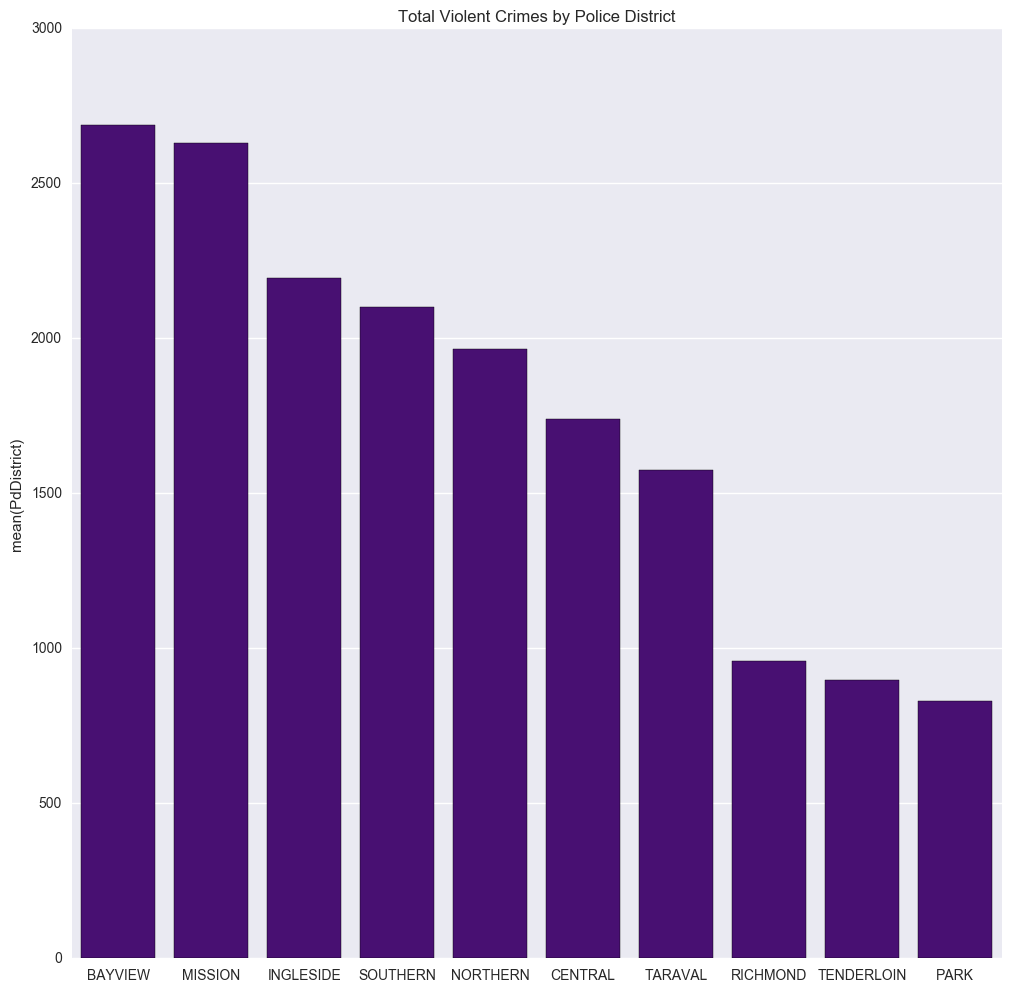

In [73]:
sns.barplot(x=districts.index.values, y=districts["PdDistrict"], data=districts,
            label="Total", color="indigo")
plt.title("Total Violent Crimes by Police District")
plt.show()

<font color="sienna">
There are definitely certain areas where violent crime seems a lot more common. Interestingly, it doesn't seem like the poor urban areas like the Tenderloin are the most violent, which is what you would expect given their reputation. It is possible that the poor and very homeless are simply more likely to comitt and be victims to other sorts of crime, or that their reputation is undeserved to begin with.

In [74]:
# DATA FRAME OF CRIME TYPES
crime_types = pd.DataFrame(violentCrime["Descript"].value_counts())
# crime_types.head()

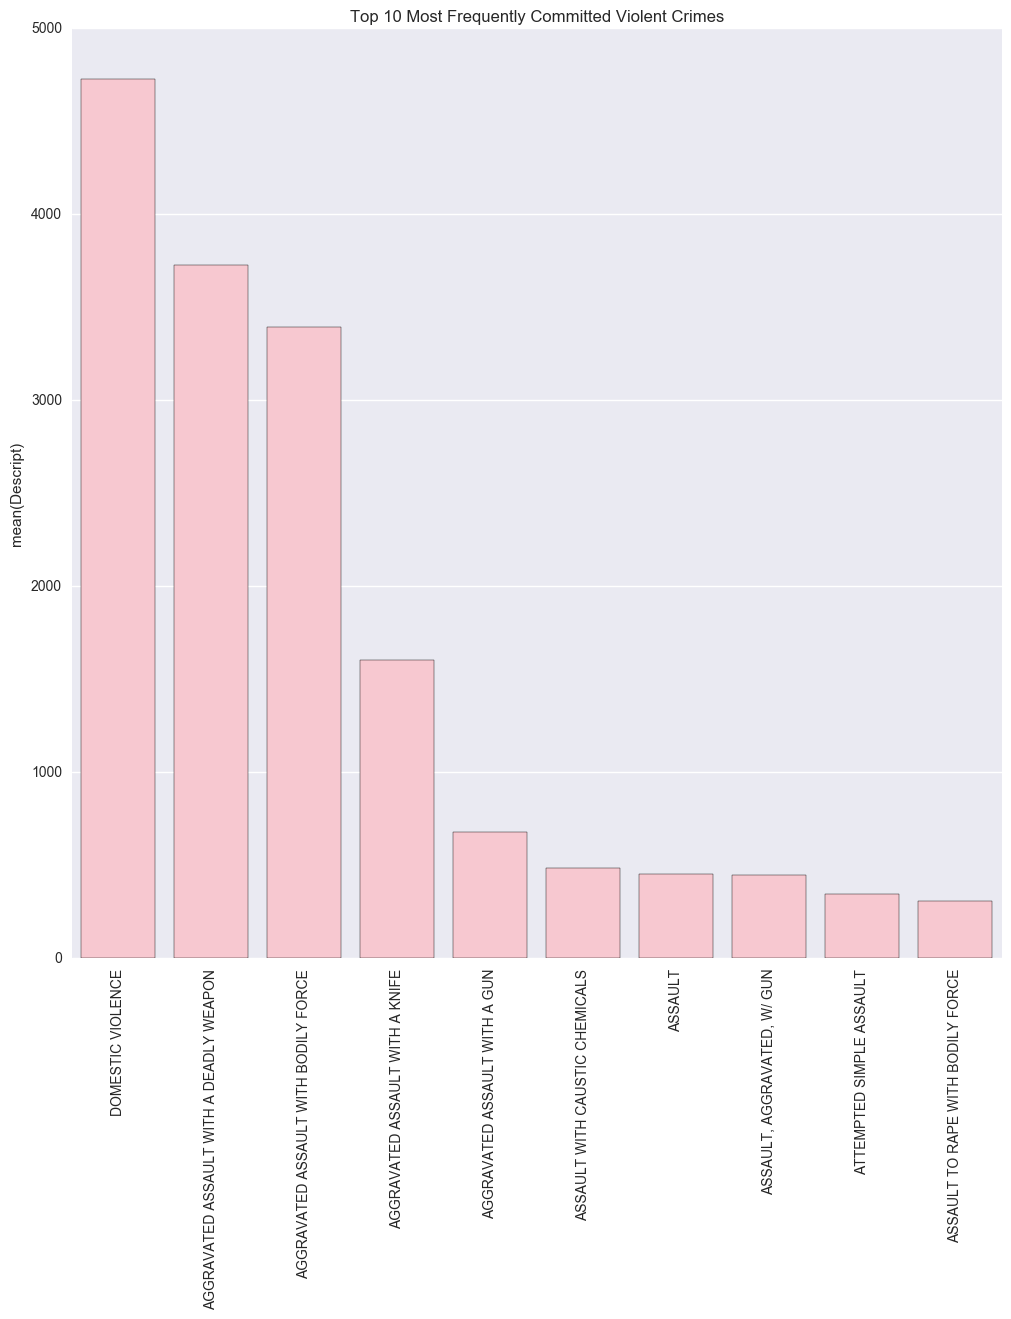

In [75]:
b = sns.barplot(x=crime_types.index.values[0:10], y=crime_types["Descript"][0:10], data=crime_types,
            label="Total", color="pink")

for item in b.get_xticklabels():
    item.set_rotation(90)

plt.title("Top 10 Most Frequently Committed Violent Crimes")
plt.show()

<font color="sienna">

The most common violent crime (by a significant margin) is domestic violence. While depressing, this isn't particularly surprising and is consistent with the general idea that personal, aggressive crimes like rape, kidnapping, and violence in general are more likely to be comitted by people the victim knows. Gun violence is, surprisingly, relatively uncommon compared with knife violence and assault with other assorted deadly weapons in general. It should be noted that there are two categories for gun violence on the chart above that were simply coded in different ways.

<font color="sienna">
### (III) Are different police precincts more likely to arrest people for violent crimes?
<br>
I broke down the percentage of incidents of domestic violence that resulted in arrests, and determined whether or not they were significantly different from the mean, then compared that with the rough average home price in those districts

In [ ]:
resolution = pd.read_sql("SELECT crime.Resolution, crime.pdDistrict FROM crime \
            INNER JOIN mobile_food_schedule \
            ON mobile_food_locations.locationid = mobile_food_schedule.locationid \
            INNER JOIN mobile_food_permits \
            ON mobile_food_permits.permit = mobile_food_schedule.permit \
            WHERE status=='APPROVED' GROUP BY Address", db)

In [238]:
#DOMESTIC VIOLENCE RESOLUTION BY DISTRICT
dv = pd.read_sql("SELECT PdDistrict, Resolution, count(Resolution) AS domviol FROM crime WHERE Descript=='DOMESTIC VIOLENCE' "
            "AND Resolution IN ('NONE', 'ARREST, BOOKED') "
            "GROUP BY PdDistrict, Resolution",db)

In [242]:
domviol_df = pd.DataFrame(dv.groupby("PdDistrict").first().domviol/dv.groupby("PdDistrict").sum().domviol)
domviol_df["domviol_c"] = 1 - domviol_df.domviol

In [266]:
#PROBABILITY OF ARREST FOR EACH POLICE DISTRICT
domviol_df

,domviol,domviol_c
PdDistrict,,
BAYVIEW,0.387442,0.612558
CENTRAL,0.424723,0.575277
INGLESIDE,0.374120,0.625880
MISSION,0.459163,0.540837
NORTHERN,0.370930,0.629070
PARK,0.338028,0.661972
RICHMOND,0.530992,0.469008
SOUTHERN,0.403509,0.596491
TARAVAL,0.399766,0.600234


<font color="sienna">
Yes, certain police departments are definitely more likely to arrest people for domestic violence than others. To test this, I ran a Chi-Squared test as seen below:

In [267]:
arrest = [[580,917], [264,363], [425, 711], [461, 543], [319, 541], [120, 235], [257, 227], [437, 646], [341, 512], [329, 319]]
chi2, p, ddof, expected = scipy.stats.chi2_contingency(arrest)
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print(msg.format(chi2, p, ddof))
print(expected)

Test Statistic: 87.3847832229
p-value: 5.44227479108e-15
Degrees of Freedom: 9

[[ 618.8020358   878.1979642 ]
 [ 259.17760618  367.82239382]
 [ 469.57856558  666.42143442]
 [ 415.01485901  588.98514099]
 [ 355.49081549  504.50918451]
 [ 146.74330174  208.25669826]
 [ 200.06692407  283.93307593]
 [ 447.67041067  635.32958933]
 [ 352.5972856   500.4027144 ]
 [ 267.85819586  380.14180414]]


<font color="sienna">
The p-value is small enough that we would be able to reject our null hypothesis (all the groups are the same) at any reasonable level of alpha. Looking at the difference between the department with the highest arrest rate and the one with the least:

In [256]:
domviol_df.loc["PARK"][1]/domviol_df.loc["RICHMOND"][1]

1.41142892597878

<font color="sienna">
We can see that the Park police department is 40% more likely than the Richmond police department to arrest people for domestic violence. I will speculate more on the reasons for that in the following question.

 <font color="sienna">
### (IV) Is there a relationship between home prices and domestic violence arrest rates?
<br>
plotting the home prices from earlier and comparing them to a map of police districts, does it seem like there is a relationship between the districts with abnormally high arrest rates and the average home price?

In [ ]:
# LOAD IN ZIP CODES
zips = gpd.read_file("cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k.shp")
#zips.head()

# NARROW IT DOWN SOME BY USING THE ZIPCODE LIST FROM SCHOOL
school_zips = np.array(["".join(re.findall("[0-9]{5}", s)) for s in pd.read_sql("SELECT Address FROM schools", db).Address.values], dtype="int64")

#NARROW DOWN UNIQUE ZIPCODES
sf_zips = zips[np.in1d(np.array(zips.GEOID10, dtype="int64"), np.unique(school_zips)) == True].reset_index(drop=True)

prices_per_zip = prices_per_zip.reset_index(drop=True).sort_values(by="RegionName")

# CREATE DATA FRAME WITH GEOMETRY, REGION, AND PRICE
df_col_merged = pd.concat([sf_zips, prices_per_zip["MedianSoldPricePerSqft_AllHomes"]], axis=1)

#REMOVE SOUTH CITY
df_col_merged = df_col_merged[df_col_merged["GEOID10"] != "94080"].reset_index(drop=True)

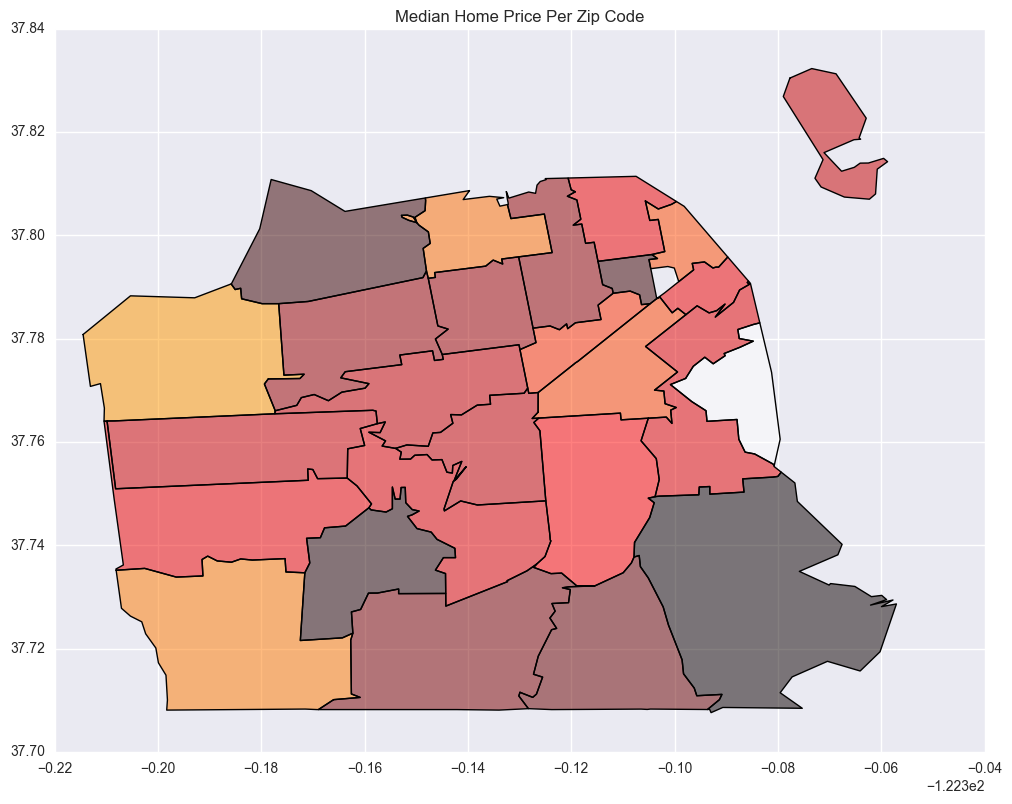

In [190]:
df_col_merged.plot(column='MedianSoldPricePerSqft_AllHomes', colormap="hot")
plt.title("Median Home Price Per Zip Code")

<h4><center>SF Police Department Map
<img src="https://lh4.googleusercontent.com/-SVEsrsxL318/VKCIq3U8lfI/AAAAAAAAbug/REilUPI6NxI/s960/SFPDdistricts2.jpg">

 <font color="sienna">
Using the maps above, I tried to compare police department domestic violence arrest rates and average home price in the zip codes covered by that department. It's difficult to derive a consistent relationship between in general, partially because the zip codes and department coverage rarely line up, but also due to simply lack of granulatity in the data. Bayview, for example, is relatively cheap with a high arrest rate while Central is expensive and also has a high arrest rate. This is because police departments that cover small areas show a more consistent relationship; the Tenderloin is very poor and has an arrest rate 1.34 times higher higher than Parks, which is on the other end of the economic spectrum. While speculation isn't particularly scientific, I'd guess that wealthier areas would have lower arrest rates for domestic violence in general as it's a very intimate crime and thus more likely that rich individuals would be the beneficieries of favoritism (and, perhaps, racial bias).

<font color="sienna">
### (V) What is the distribution of high schools in the City?
<br>
I am going to plot high schools based on school category, where 'High schools' are defined as having a "lower grade" of 9.

In [264]:
highschools = pd.read_sql("SELECT * FROM schools WHERE LowerGrade=9 ORDER BY Category", db)
# highschools.head()

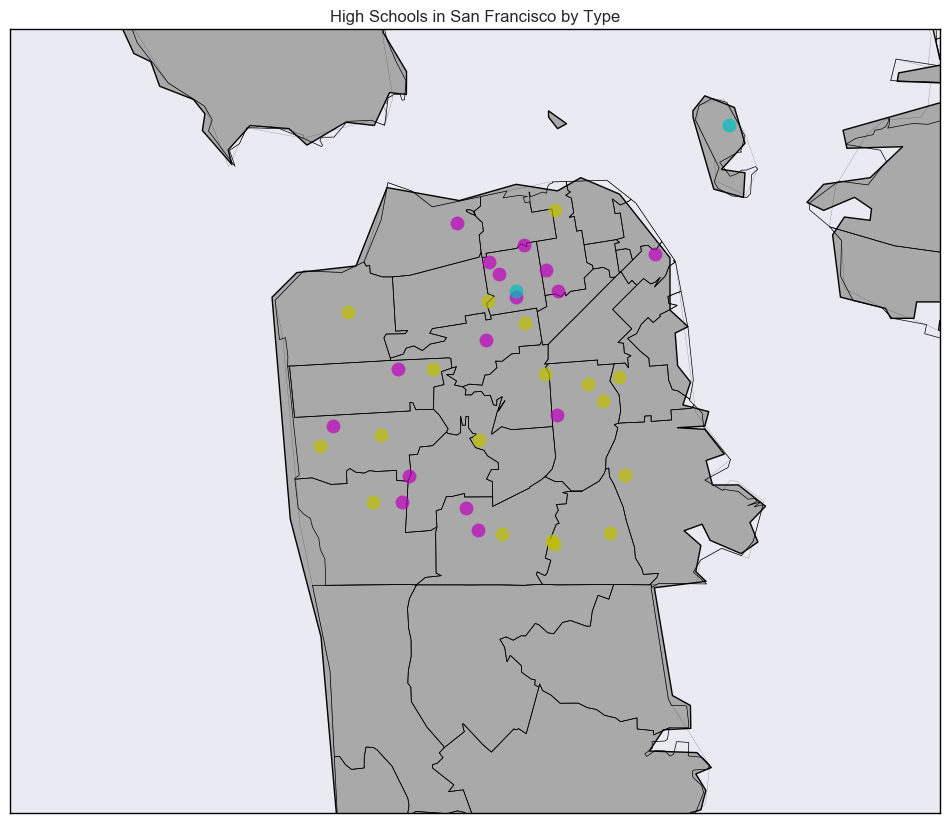

In [265]:
# INITIALIZE BASEMAP
hs_map = Basemap(projection="merc", llcrnrlon=-122.6, llcrnrlat=37.65, urcrnrlon=-122.3, urcrnrlat=37.85, resolution="h", area_thresh = 0.1)

# DRAW IN LINES AND SHAPEFILE
hs_map.drawcoastlines()
hs_map.drawmapboundary()
hs_map.drawcounties()
hs_map.readshapefile("cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k", "zips")

# RECOLOR
hs_map.fillcontinents(color="darkgrey")

# ADD SCATTER
for lon, lat, category in zip(highschools.Lon, highschools.Lat, highschools.Category):
    x, y = hs_map(lon, lat)
    
    color = "k"
    
    # YELLOW PUBLIC SCHOOLS
    if category == "USD Grades 9-12":
        color = "y"
    
    # CHARTER SCHOOLS
    if category == "USD Charter School":
        color = "c"
    
    # PRIVATE SCHOOLS
    if category == "Independent / Private":
        color = "m"
        
    hs_map.plot(x, y, color + "o", markersize = 10, alpha = 0.7)

plt.title("High Schools in San Francisco by Type")
plt.show()

<font color="sienna">
<font color="magenta"><b>Magenta</b></font> - Private, <font color="cyan"><b>Cyan</b></font> - USD Charter School, <font color="#FDE21F"><b>Yellow</b></font> - USD Grades 9-12

<font color="sienna">
Are high schools offered only in specific areas? The following plot shows high schools plottted upon the map of zip codes, shaded by price of housing. What is obvious in this map is that wealthier areas have more high schools. This is curious because we would not expect that poorer places would have fewer students of high school age. In fact, given the demographics (poorer people tend to have more kids)

(37.697639885837305, 37.842298)

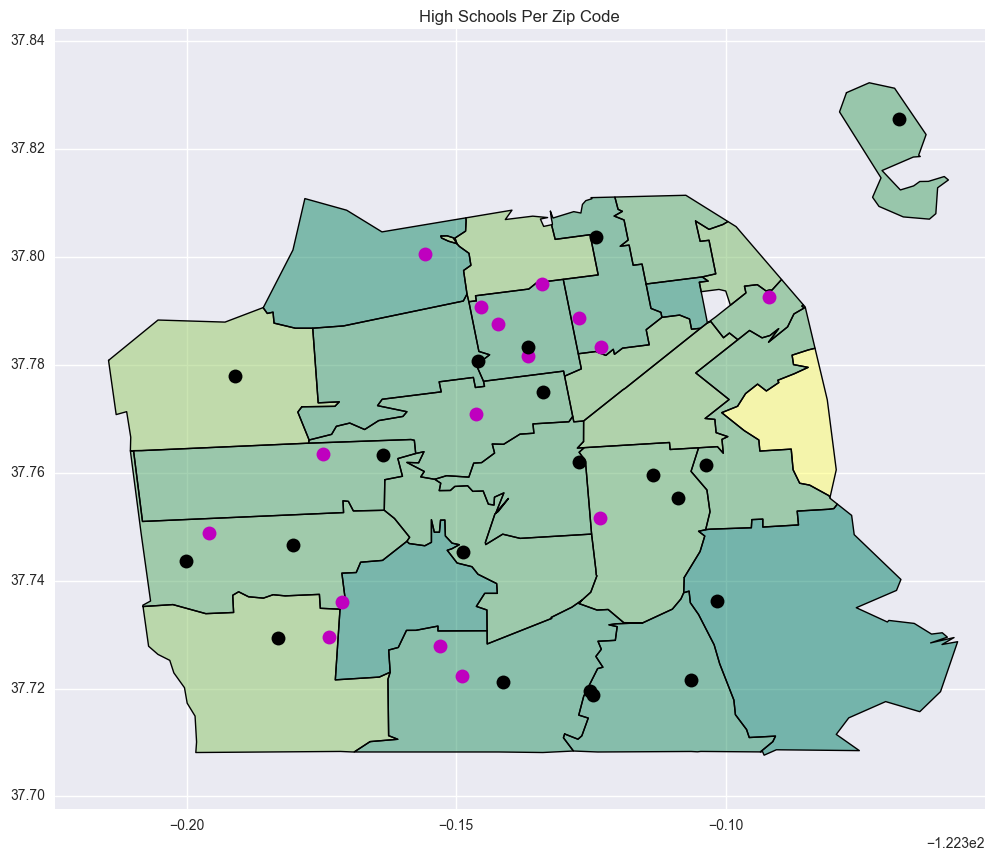

In [335]:
sf_plot = df_col_merged.plot(column='MedianSoldPricePerSqft_AllHomes', colormap="summer")


for lon, lat, category in zip(highschools.Lon, highschools.Lat, highschools.Category):
    x, y = (lon, lat)
    color = "k"
    if category == "Independent / Private":
        color = "m"
    
    sf_plot.plot(x, y, color + "o", markersize = 10)

plt.title("High Schools Per Zip Code")

bounds = df_col_merged.geometry.bounds

plt.xlim([bounds.minx.min()-0.01, bounds.maxx.max()+0.005])
plt.ylim([bounds.miny.min()-0.01, bounds.maxy.max()+0.01])

<font color="sienna">
<font color="black"><b>Black</b></font> - Public <font color="black">|</font> <font color="magenta"><b>Magenta</b></font> - Private
<br><br>
This leads to some interesting observations:
<br><br>
<ol>
    <li>There are so few high schools in less wealthy areas because there are a quite uniform number of private and public schools throughout the City, and that private schools only cater to areas that have higher income families.</li>
    <li>There are no private schools in poorer areas, which is unsurprising as people in those areas are less likely to be able to afford it</li>
    <li>The  number of public and private high schools in SF are almost equal, which is unusual given the expense of these schools. Given that approximately 1/3rd of SF students attend private schools, this speaks to both serious overcrowding the a general lack of economic and educational equality. </li>
</ol>
